In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics
#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests
nan=np.nan

In [189]:
DBGmode = 0
WritetoFile = 0
pd.set_option('display.max_rows', 10)
ticker = 'PYPL'
st_date = '2017-9-11'
en_date = '2020-9-11'

In [190]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [191]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-191-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [192]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [193]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [194]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [195]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [196]:
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [197]:
datastock['Close']=closes

if DBGmode == 1:
    datastock

In [198]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [199]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))
data=pd.concat([datastock, us10y_data], axis=1, sort=False)

#fill US10Y NaN with previous value
data['US10Y'].fillna(method='ffill', inplace=True)

if DBGmode==1:
    #pd.set_option('display.max_rows', None)
    print(data)

Total Stock Rows =  757
Total US10Y Rows =  751


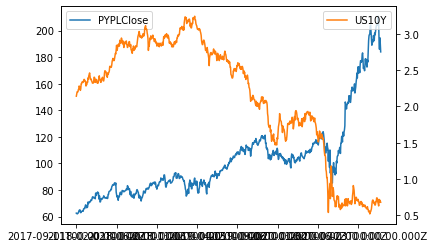

In [200]:
plt.figure()
data.Close.plot(label=ticker+'Close')
plt.legend()
data.US10Y.plot(secondary_y=True, label='US10Y')
plt.legend()
#plt.plot(data['Close'], label=ticker+' Closes')
#plt.plot(data['US10Y'], label='US10Y')
plt.show()

In [201]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

if DBGmode == 1:
    #scaled_data = data['Close']
    print(scaled_data)

In [202]:
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    train_data

In [203]:
def create_dataset(dataset, timestep=1):
    data_x, data_y = [], []
    #for i in range(len(dataset) - timestep - 1):
        #data_x.append(dataset[i:(i+timestep),0])
        #data_y.append(dataset[i+timestep,0])
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:2])
        data_y.append(dataset[i+timestep,0])
    return np.array(data_x), np.array(data_y)

In [204]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

if DBGmode == 1:
    train_x

In [205]:
if DBGmode == 1:
    train_y

In [206]:
if DBGmode == 1:
    print('train_x shape = ', train_x.shape)
    print('test_x shape = ', test_x.shape)
    print('train_y shape = ', train_y.shape)
    print('test_y shape = ', test_y.shape)

In [207]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[data_noofcols]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[data_noofcols]))

if DBGmode == 1:
    train_x

Number of data columns =  2


In [208]:
model = Sequential()
model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
#model.add(Dense(6, activation='relu'))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 256)               265216    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 265,473
Trainable params: 265,473
Non-trainable params: 0
_________________________________________________________________
None


In [209]:
model.fit(train_x, train_y, epochs=10, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/10
528/528 [==============================] - 1s 1ms/step - loss: 0.0139 - accuracy: 0.0019
Epoch 2/10
528/528 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 0.0019
Epoch 3/10
528/528 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 0.0019
Epoch 4/10
528/528 [==============================] - 1s 1ms/step - loss: 7.5282e-04 - accuracy: 0.0019
Epoch 5/10
528/528 [==============================] - 1s 1ms/step - loss: 4.5061e-04 - accuracy: 0.0019
Epoch 6/10
528/528 [==============================] - 1s 1ms/step - loss: 4.0825e-04 - accuracy: 0.0019
Epoch 7/10
528/528 [==============================] - 1s 1ms/step - loss: 3.6911e-04 - accuracy: 0.0019
Epoch 8/10
528/528 [==============================] - 1s 1ms/step - loss: 3.7239e-04 - accuracy: 0.0019
Epoch 9/10
528/528 [==============================] - 1s 1ms/step - loss: 3.6738e-04 - accuracy: 0.0019
Epoch 10/10
528/528 [==============================] - 1s 1ms/step - loss: 3

In [210]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [211]:
# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols) )
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols) )
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [212]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [213]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[1:len(train_predictions)+1] = train_predictions

In [214]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+2:len(scaled_data)] = test_predictions

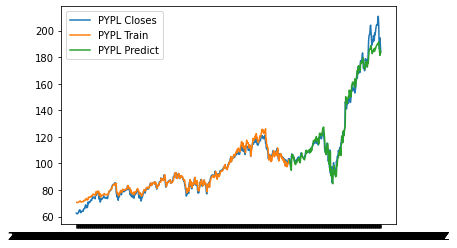

In [215]:
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train')
plt.plot(test_predict_plot, label = ticker+' Predict')
plt.legend()
plt.show()

In [216]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  757
Length of Train data =  528
Length of test data =  227


In [217]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data.tail()

,Close,US10Y,AITrain,AITest
2020-09-04T00:00:00.000Z,191.84,0.72,NaN,189.395282
2020-09-08T00:00:00.000Z,185.95,0.69,NaN,184.410839
2020-09-09T00:00:00.000Z,194.60,0.71,NaN,181.341534
2020-09-10T00:00:00.000Z,190.09,0.68,NaN,185.619190
2020-09-11T00:00:00.000Z,184.00,0.68,NaN,183.394693


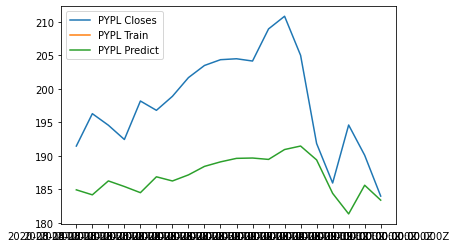

In [218]:
#plt.plot(data.Close[-40:-20], label = ticker+' Closes')
plt.plot(data.Close[-20:], label = ticker+' Closes')
plt.plot(train_predict_plot[-20:], label = ticker+' Train')
plt.plot(test_predict_plot[-20:], label = ticker+' Predict')
plt.legend()
plt.show()

In [219]:
data['Abs%Err']=nan
data['DirErr']=1

In [220]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+3,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['Close'][i]-data['AITest'][i-1])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+4,len(scaled_data)):
    if ((data['Close'][i] > data['Close'][i-1]) and (data['AITest'][i-1] > data['AITest'][i-2])):
        data['DirErr'][i]=0
    if ((data['Close'][i] < data['Close'][i-1]) and (data['AITest'][i-1] < data['AITest'][i-2])):
        data['DirErr'][i]=0

if DBGmode==1:
    print('Train length = ', len(train_predictions)+1)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[AITest][i-2]= ', data['AITest'][ch-2])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

data.tail()

<ipython-input-220-033daf45973e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Abs%Err'][i]=100*(data['Close'][i]-data['AITest'][i-1])/data['Close'][i]
<ipython-input-220-033daf45973e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DirErr'][i]=0
<ipython-input-220-033daf45973e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DirErr'][i]=0


,Close,US10Y,AITrain,AITest,Abs%Err,DirErr
2020-09-04T00:00:00.000Z,191.84,0.72,NaN,189.395282,0.195458,1
2020-09-08T00:00:00.000Z,185.95,0.69,NaN,184.410839,-1.852800,0
2020-09-09T00:00:00.000Z,194.60,0.71,NaN,181.341534,5.235951,1
2020-09-10T00:00:00.000Z,190.09,0.68,NaN,185.619190,4.602276,0
2020-09-11T00:00:00.000Z,184.00,0.68,NaN,183.394693,-0.879995,1


In [221]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+2:len(scaled_data)])
Tot_test_len = len(scaled_data)-len(train_predictions)+2
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('----STOCK PRICE PREDICTION-----')
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+3:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+3:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+3:len(scaled_data)]))

----DIRECTION-----
Total Test Errors =  116
Total Test Elements =  231
Test Direction Predict Accuracy =  49.78354978354978
----STOCK PRICE PREDICTION-----
Max % Price Error =  13.325297891160618
Min % Price Error =  -11.855205497627612
Average % Price Error =  0.9915400910936205


In [222]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')